### Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load in data
train_features = pd.read_csv('data/training_set_features.csv')
train_labels = pd.read_csv('data/training_set_labels.csv')

train_df = pd.merge(train_labels, train_features, on='respondent_id')
train_df.set_index('respondent_id', inplace=True)

In [3]:
# Examine the dataset's shape
print(f'train_df.shape: {train_df.shape}')

train_df.shape: (26707, 37)


In [4]:
# Examine the dataset's datatypes
train_df.dtypes

h1n1_vaccine                     int64
seasonal_vaccine                 int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                     

### Choosing our target

In [5]:
# Examine the vaccination value counts
for vaccine in ['seasonal_vaccine', 'h1n1_vaccine']:
    print(train_df[vaccine].value_counts())

# Given that seasonal vaccine has a better class balance, we'll choose that as our target

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64
0    21033
1     5674
Name: h1n1_vaccine, dtype: int64


### Handling Nulls

In [6]:
train_df.isnull().sum()

h1n1_vaccine                       0
seasonal_vaccine                   0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
i

In [7]:
missing_data = train_df.isnull().sum()
missing_data_pct = missing_data / len(train_df)
missing_data_pct[missing_data_pct > .3]

health_insurance         0.459580
employment_industry      0.499120
employment_occupation    0.504362
dtype: float64

In [8]:
train_df['health_insurance'].fillna(0, inplace=True)
train_df.drop(columns=['employment_industry', 'employment_occupation'], inplace=True)
train_df.shape

(26707, 35)

### Reconciling Datatypes

In [9]:
string_representations = [feature for feature in train_df.columns if train_df[feature].dtype == 'object']
string_representations

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

In [10]:
train_df_encoded = pd.get_dummies(train_df, columns=string_representations)
encoded_columns = [col for col in train_df_encoded.columns if any(col.startswith(str_col) for str_col in string_representations)]
train_df_encoded[encoded_columns].dtypes

age_group_18 - 34 Years                     uint8
age_group_35 - 44 Years                     uint8
age_group_45 - 54 Years                     uint8
age_group_55 - 64 Years                     uint8
age_group_65+ Years                         uint8
education_12 Years                          uint8
education_< 12 Years                        uint8
education_College Graduate                  uint8
education_Some College                      uint8
race_Black                                  uint8
race_Hispanic                               uint8
race_Other or Multiple                      uint8
race_White                                  uint8
sex_Female                                  uint8
sex_Male                                    uint8
income_poverty_<= $75,000, Above Poverty    uint8
income_poverty_> $75,000                    uint8
income_poverty_Below Poverty                uint8
marital_status_Married                      uint8
marital_status_Not Married                  uint8


In [11]:
train_df_encoded.shape

(26707, 63)

### Examining Feature Correlations

In [12]:
corr_mat = train_df_encoded.corr()
corr_mat[corr_mat == 1] = np.nan
five_most_correlated = corr_mat.unstack().sort_values(
    ascending=False
).drop_duplicates()[:5]

print(five_most_correlated)

doctor_recc_seasonal         doctor_recc_h1n1                        0.591868
behavioral_large_gatherings  behavioral_outside_home                 0.584085
opinion_h1n1_risk            opinion_seas_risk                       0.564208
age_group_65+ Years          employment_status_Not in Labor Force    0.498880
opinion_seas_sick_from_vacc  opinion_h1n1_sick_from_vacc             0.491546
dtype: float64


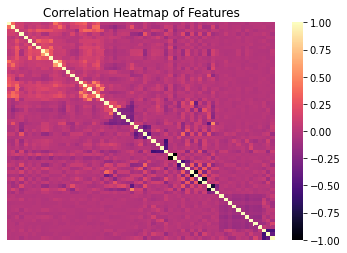

In [13]:

sns.heatmap(train_df_encoded.corr(), cmap='magma')
plt.title('Correlation Heatmap of Features')
plt.xticks([])
plt.yticks([]);

## Preparing for Model Building

In [14]:
from sklearn.model_selection import train_test_split

target = 'seasonal_vaccine' # We want to predict seasonal vaccine

# We choose behavioral features + doctor recommendations for the vaccines as our features.
chosen_features = [column for column in train_df if "behavioral" in column] + \
                  ['doctor_recc_h1n1' ,'doctor_recc_seasonal']

X = train_df_encoded[chosen_features]
y = train_df_encoded[target]

seed = 42 # For reproducability
test_size = .2 # 20% of our data will be in the testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21365, 9), (5342, 9), (21365,), (5342,))

In [15]:
from sklearn.impute import SimpleImputer

def simple_impute(*Xs):
    results = []
    imputer = SimpleImputer(strategy='most_frequent')
    for X in Xs:
        X_imputed = imputer.fit_transform(X)
        X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
        results.append(X_imputed)
    return tuple(results)

In [16]:
X_train, X_test = simple_impute(X_train, X_test)

print(f'Null values in X_train: {X_train.isnull().sum().sum()}')
print(f'Null values in X_test: {X_test.isnull().sum().sum()}')

Null values in X_train: 0
Null values in X_test: 0


In [17]:
print(f'Null values in y_train: {y_train.isnull().sum().sum()}')
print(f'Null values in y_test: {y_test.isnull().sum().sum()}')

Null values in y_train: 0
Null values in y_test: 0


## Building Models

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from model_iteration import ModelIteration

iterations = ModelIteration()

### Model 1: Simple Model (Logistic Regression)

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489


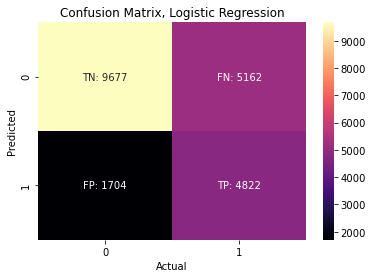

In [19]:
model_1 = 'Logistic Regression'
simple_model = make_pipeline(StandardScaler(), LogisticRegression(random_state=seed))
iterations.run_cv(model_1, simple_model, X_train, y_train)

iterations.get_stats()
iterations.confusion(simple_model, model_1, X_train, y_train)

### Model 2: Tuned Logistic Regression

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625


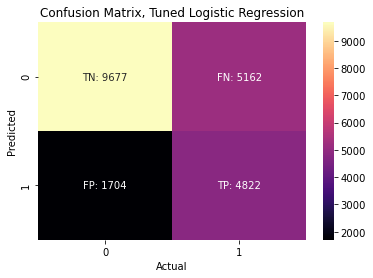

In [20]:
param_grid_1 = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

tuned_simple_model, tuned_simple_model_params = iterations.tune(
    simple_model, param_grid_1, X_train, y_train
)

model_2 = 'Tuned Logistic Regression'
iterations.run_cv(model_2, tuned_simple_model, X_train, y_train)

iterations.get_stats()
iterations.confusion(tuned_simple_model, model_2, X_train, y_train)

In [21]:
print(tuned_simple_model_params)

{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


### Model 3: Decision Tree

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736


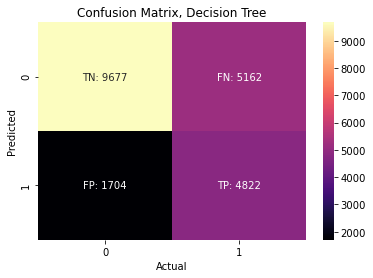

In [22]:
from sklearn.tree import DecisionTreeClassifier

model_3 = 'Decision Tree'
tree_model = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=seed))
iterations.run_cv(model_3, tree_model, X_train, y_train)
iterations.get_stats()
iterations.confusion(simple_model, model_3, X_train, y_train)

### Model 4: Tuned Decision Tree

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.491987,0.492839,0.588266,0.589484,0.696017,0.707725


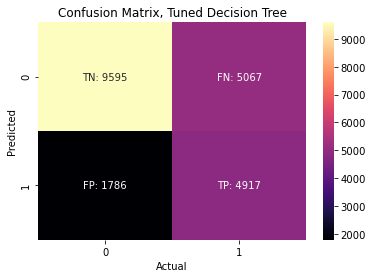

In [23]:
param_grid_2 = {
    'decisiontreeclassifier__max_depth': [None] + list(range(1, 101)),
    'decisiontreeclassifier__min_samples_split': range(2, 101),
    'decisiontreeclassifier__min_samples_leaf': range(1, 101),
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

tuned_tree_model, tuned_tree_model_params = iterations.tune(
    tree_model, param_grid_2, X_train, y_train, method='random'
)

model_4 = 'Tuned Decision Tree'
iterations.run_cv(model_4, tuned_tree_model, X_train, y_train)

iterations.get_stats()
iterations.confusion(tuned_tree_model, model_4, X_train, y_train)

In [24]:
print(tuned_tree_model_params)

{'decisiontreeclassifier__min_samples_split': 98, 'decisiontreeclassifier__min_samples_leaf': 24, 'decisiontreeclassifier__max_depth': 98, 'decisiontreeclassifier__criterion': 'entropy'}


### Model 5: Random Forest

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.491987,0.492839,0.588266,0.589484,0.696017,0.707725
Random Forest,0.488382,0.496795,0.583760,0.593933,0.691192,0.714471


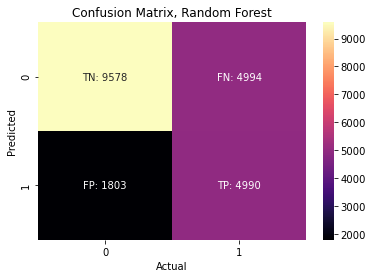

In [25]:
from sklearn.ensemble import RandomForestClassifier

model_5 = 'Random Forest'
forest_model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=seed))
iterations.run_cv(model_5, forest_model, X_train, y_train)
iterations.get_stats()
iterations.confusion(forest_model, model_5, X_train, y_train)

### Model 6: Tuned Random Forest

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.491987,0.492839,0.588266,0.589484,0.696017,0.707725
Random Forest,0.488382,0.496795,0.583760,0.593933,0.691192,0.714471
Tuned Random Forest,0.493089,0.496269,0.588286,0.592049,0.694409,0.711207


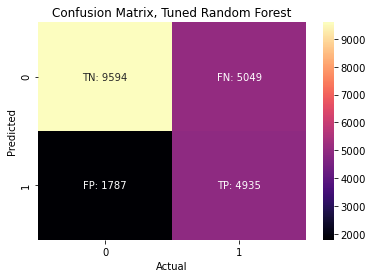

In [26]:
param_grid_3 = {
    'randomforestclassifier__n_estimators': range(50, 200),
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__max_depth': [None] + list(range(5, 50)),
    'randomforestclassifier__min_samples_split': range(2, 20),
    'randomforestclassifier__min_samples_leaf': range(1, 20),
    'randomforestclassifier__bootstrap': [True, False]
}


tuned_forest_model, tuned_forest_model_params = iterations.tune(
    forest_model, param_grid_3, X_train, y_train, method='random'
)

model_6 = 'Tuned Random Forest'
iterations.run_cv(model_6, tuned_forest_model, X_train, y_train)

iterations.get_stats()
iterations.confusion(tuned_forest_model, model_6, X_train, y_train)

In [27]:
print(tuned_forest_model_params)

{'randomforestclassifier__n_estimators': 127, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': 45, 'randomforestclassifier__bootstrap': True}


### Model 7: Tuned Random Forest (New Features)

In [28]:
new_features = chosen_features.copy()

new_features += [
    col for col in train_df_encoded.columns \
        if 'opinion' in col \
        or 'education' in col \
        or 'age' in col \
        or col == 'h1n1_vaccine' \
        or col == 'health_insurance'
]

len(new_features)

26

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.491987,0.492839,0.588266,0.589484,0.696017,0.707725
Random Forest,0.488382,0.496795,0.583760,0.593933,0.691192,0.714471
Tuned Random Forest,0.493089,0.496269,0.588286,0.592049,0.694409,0.711207
Random Forest (New Features),0.766226,0.829127,0.775826,0.841527,0.871162,0.937935


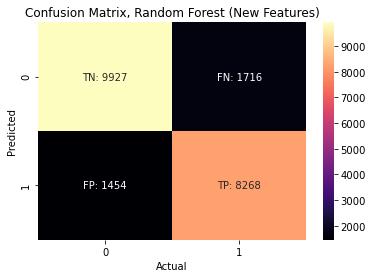

In [38]:
model_7 = 'Random Forest (New Features)'
X_nf = train_df_encoded[new_features].copy()

X_train_nf, X_test_nf, _, _ = train_test_split(X_nf, y, random_state=seed, test_size=test_size)
X_train_nf, X_test_nf = simple_impute(X_train_nf, X_test_nf)

iterations.run_cv(model_7, tuned_forest_model, X_train_nf, y_train)

iterations.get_stats()
iterations.confusion(tuned_forest_model, model_7, X_train_nf, y_train)

,Test Recall,Train Recall,Test F1,Train F1,Test Roc Auc,Train Roc Auc
Model,,,,,,
Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.700007,0.700489
Tuned Logistic Regression,0.482973,0.482973,0.584092,0.584128,0.666625,0.666625
Decision Tree,0.484776,0.494066,0.581709,0.592603,0.691312,0.714736
Tuned Decision Tree,0.491987,0.492839,0.588266,0.589484,0.696017,0.707725
Random Forest,0.488382,0.496795,0.583760,0.593933,0.691192,0.714471
Tuned Random Forest,0.493089,0.496269,0.588286,0.592049,0.694409,0.711207
Random Forest (New Features),0.766226,0.829127,0.775826,0.841527,0.871162,0.937935
Tuned Random Forest (New Features),0.766226,0.829327,0.775786,0.841548,0.871153,0.937946


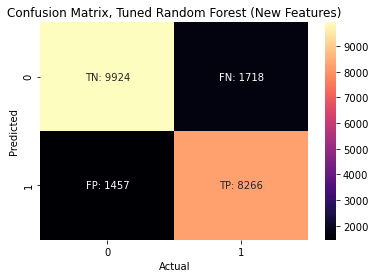

In [40]:
tuned_forest_model_nf, tuned_forest_model_nf_params = iterations.tune(
    tuned_forest_model, param_grid_3, X_train_nf, y_train, method='random'
)

model_8 = 'Tuned Random Forest (New Features)'
iterations.run_cv(model_8, tuned_forest_model_nf, X_train_nf, y_train)

iterations.get_stats()
iterations.confusion(tuned_forest_model_nf, model_8, X_train_nf, y_train)

In [54]:
from sklearn.metrics import recall_score, accuracy_score

tuned_forest_model.fit(X_train_nf, y_train)

y_pred = tuned_forest_model.predict(X_test_nf)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy Score on Test Data: {accuracy:,.4f}')
print(f'Recall Score on Test Data: {recall:,.4f}')

Accuracy Score on Test Data: 0.7939
Recall Score on Test Data: 0.7666
